# Khai báo thư viện

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from pmdarima  import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error,accuracy_score,mean_absolute_percentage_error,mean_absolute_error
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout, Input,GRU
from statsmodels.tsa.statespace.sarimax import SARIMAX
# import xgboost as xgb
from keras import Model
from keras.models import Model, load_model
import math
import warnings
warnings.filterwarnings("ignore")
warnings.warn("this will not show")

plt.rcParams["figure.figsize"] = (10,6)
sns.set_style("whitegrid")
pd.set_option('display.float_format', lambda x: '%.3f' % x)
pd.set_option('display.max_columns', None)

# Đọc Dữ Liệu

In [45]:
df = pd.read_csv('Amazon_Stock_Price.csv')
df.head(5)

,Unnamed: 0,Date,Open,High,Low,Close,Volume
0,0,2000-01-03,4.075,4.478,3.952,4.469,322352000
1,1,2000-01-04,4.269,4.575,4.088,4.097,349748000
2,2,2000-01-05,3.525,3.756,3.400,3.487,769148000
3,3,2000-01-06,3.566,3.634,3.200,3.278,375040000
4,4,2000-01-07,3.350,3.525,3.309,3.478,210108000


In [46]:
df = pd.read_csv('Amazon_Stock_Price.csv',
                 parse_dates=True
                )

In [47]:
df.drop(columns=['Unnamed: 0'],axis=1,inplace=True)
df.drop(columns=['Volume'],axis=1,inplace=True)

In [48]:
df['Date'] = pd.to_datetime(df['Date'])
df.sort_values(by='Date', ascending=True, inplace=True)
df.reset_index(drop=True, inplace=True)

## Data Overview

In [49]:
df.head(10)

,Date,Open,High,Low,Close
0,2000-01-03,4.075,4.478,3.952,4.469
1,2000-01-04,4.269,4.575,4.088,4.097
2,2000-01-05,3.525,3.756,3.400,3.487
3,2000-01-06,3.566,3.634,3.200,3.278
4,2000-01-07,3.350,3.525,3.309,3.478
5,2000-01-10,3.628,3.631,3.278,3.459
6,2000-01-11,3.344,3.500,3.250,3.338
7,2000-01-12,3.394,3.400,3.150,3.178
8,2000-01-13,3.247,3.359,3.156,3.297
9,2000-01-14,3.338,3.431,3.200,3.213


In [50]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6050 entries, 0 to 6049
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Date    6050 non-null   datetime64[ns]
 1   Open    6050 non-null   float64       
 2   High    6050 non-null   float64       
 3   Low     6050 non-null   float64       
 4   Close   6050 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 236.5 KB


# Trực quan hóa dữ liệu

Kiểm tra tính dừng của dữ liệu

In [51]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(df['Close'])
print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])

ADF Statistic: 0.427528
p-value: 0.982496


Biểu đồ thời gian về giá đóng của cố phiếu

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


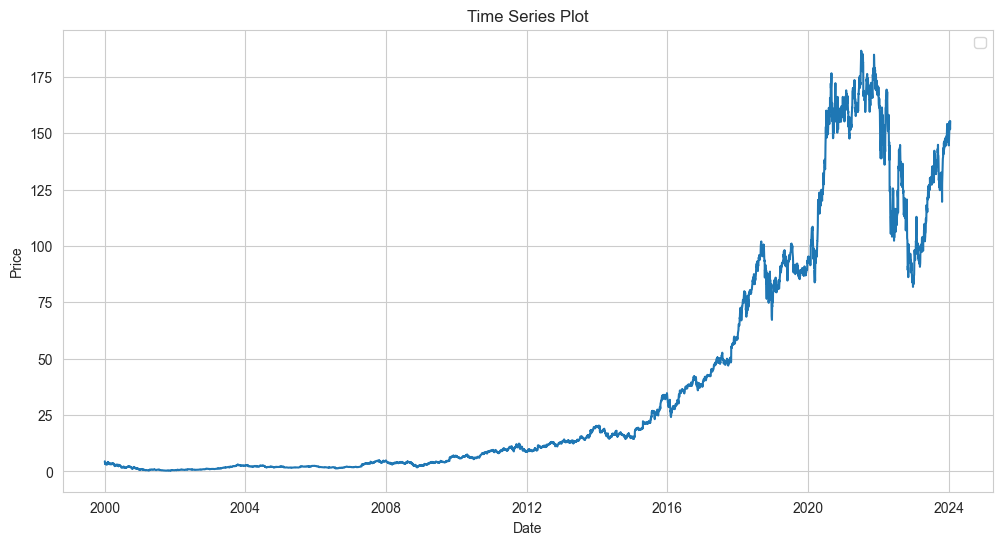

In [52]:
price_data = df['Close']
date_data = df['Date']
plt.figure(figsize=(12, 6))
plt.plot(date_data,price_data)
plt.title('Time Series Plot')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

Biểu đồ về trend , seasonal và resid của dữ liệu

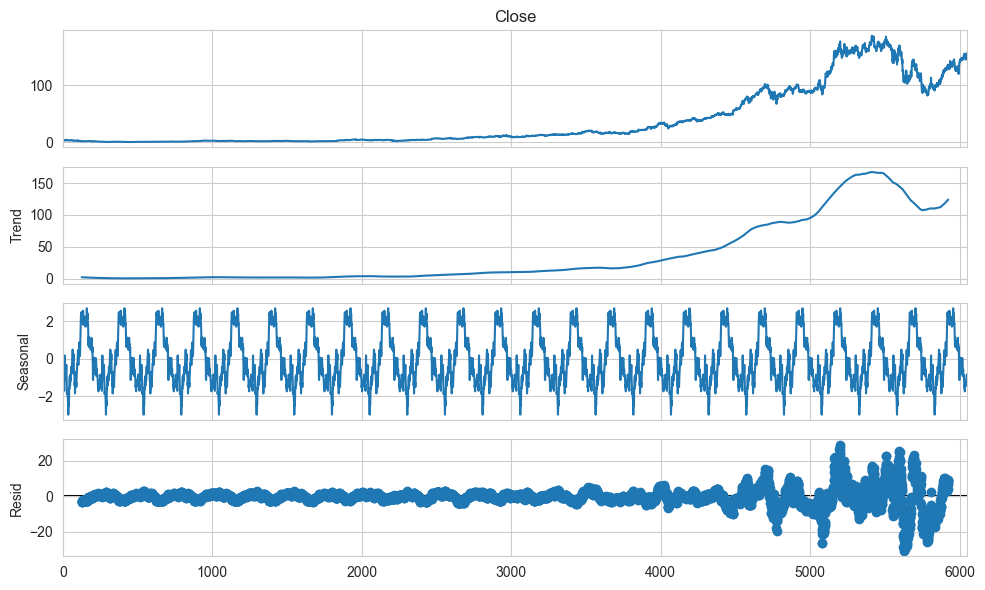

In [53]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Decompose chuỗi thời gian
decomposition = seasonal_decompose(price_data, model='additive', period=252)  # Giả sử chu kỳ mùa vụ là 252 (ngày giao dịch trong 1 năm)
fig = decomposition.plot()
plt.show()

Biểu đồ tương quan (autocorrelation)

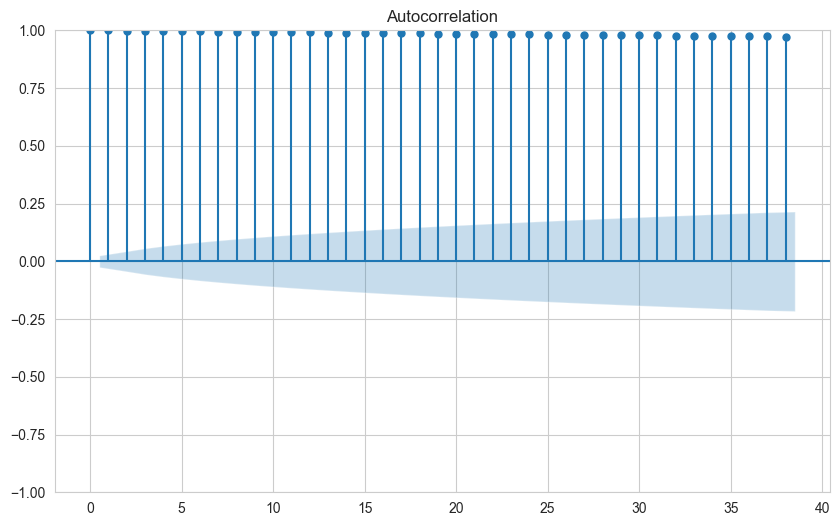

In [54]:
from statsmodels.graphics.tsaplots import plot_acf

plot_acf(df['Close'])
plt.show()

Biều đồ giá cổ phiếu 

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


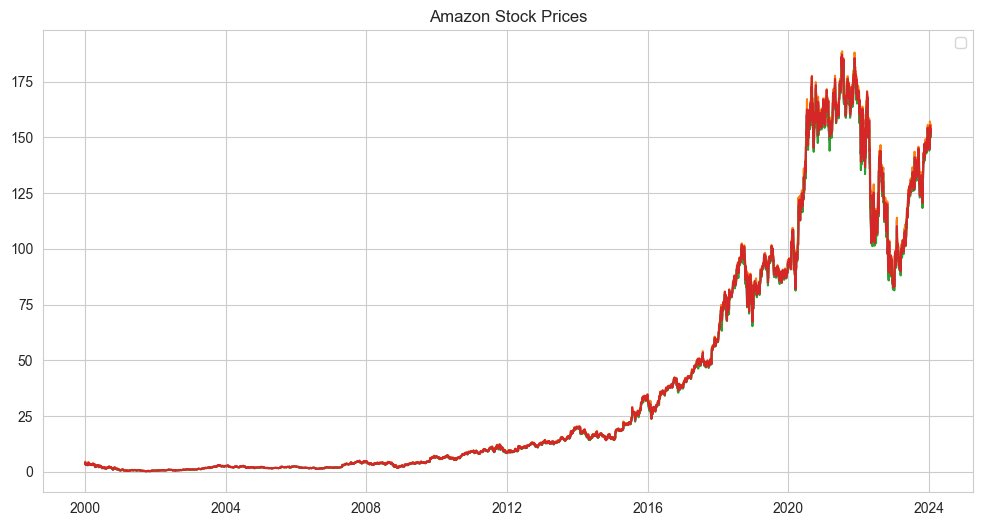

In [55]:
df_plt = df[['Close','High','Low','Open']]
plt.figure(figsize=(12, 6))
plt.plot(date_data,df_plt)
plt.title('Amazon Stock Prices')
plt.legend()

<Axes: >

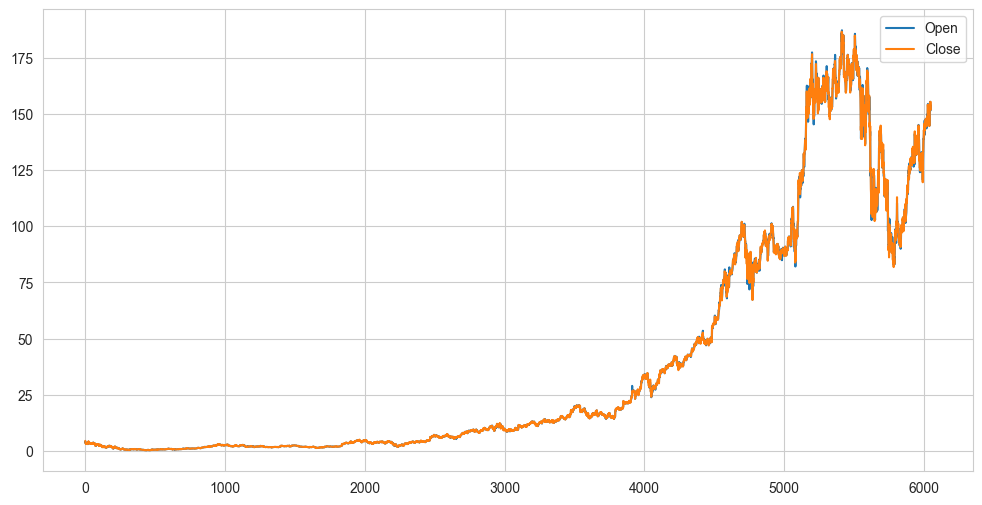

In [56]:
df[['Open','Close']].plot(figsize=(12,6))

# Chia dữ liệu thành tập huyến luyện và tập kiểm thử

In [57]:
test_size = df[df.Date.dt.year==2024].shape[0]
test_size

13

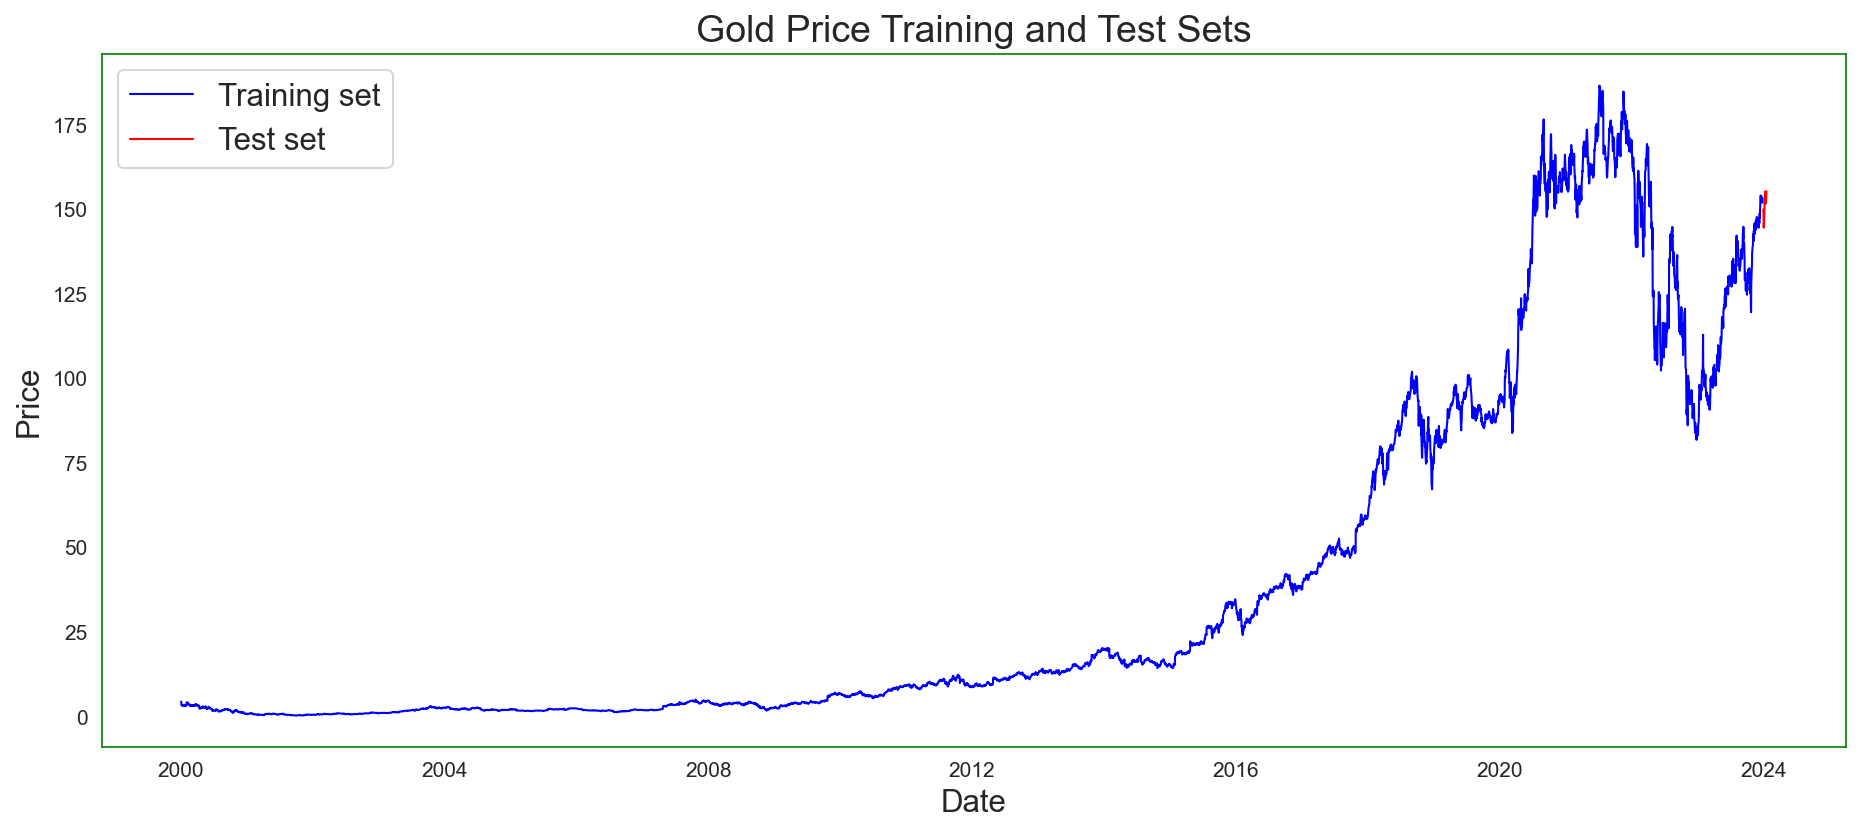

In [58]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'white'
plt.rc('axes',edgecolor='green')
plt.plot(df.Date[:-test_size], df.Close[:-test_size], color='blue', lw=1)
plt.plot(df.Date[-test_size:], df.Close[-test_size:], color='red', lw=1)
plt.title('Gold Price Training and Test Sets', fontsize=18)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.legend(['Training set', 'Test set'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

In [59]:
from sklearn.preprocessing import MinMaxScaler

In [60]:
scaler = MinMaxScaler()
scaler.fit(df.Close.values.reshape(-1,1))

MinMaxScaler()

In [61]:
window_size = 60

Trainning set:

In [62]:
train_data = df.Close[:-test_size]
train_data = scaler.transform(train_data.values.reshape(-1,1))

In [63]:
X_train = []
y_train = []

for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-60:i, 0])
    y_train.append(train_data[i, 0])

Test set:

In [64]:
test_data = df.Close[-test_size-60:]
test_data = scaler.transform(test_data.values.reshape(-1,1))

In [65]:
X_test = []
y_test = []

for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-60:i, 0])
    y_test.append(test_data[i, 0])

# Chuyển dữ liệu sang Numpy Arrays

In [69]:
X_train = np.array(X_train)
X_test  = np.array(X_test)
y_train = np.array(y_train)
y_test  = np.array(y_test)

In [70]:
X_train = np.reshape(X_train, (X_train.shape[0], X_train.shape[1], 1))
X_test  = np.reshape(X_test, (X_test.shape[0], X_test.shape[1], 1))
y_train = np.reshape(y_train, (-1,1))
y_test  = np.reshape(y_test, (-1,1))

In [71]:
print('X_train Shape: ', X_train.shape)
print('y_train Shape: ', y_train.shape)
print('X_test Shape:  ', X_test.shape)
print('y_test Shape:  ', y_test.shape)

X_train Shape:  (5977, 60, 1)
y_train Shape:  (5977, 1)
X_test Shape:   (13, 60, 1)
y_test Shape:   (13, 1)


# Khởi tạo model

## Model LSTM

In [72]:
def define_model_lstm():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 128, return_sequences=True)(input1)  
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 32,return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 16)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    
    return model

In [73]:
model_lstm = define_model_lstm()
history = model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Model: "functional_9"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_16 (LSTM)                  │ (None, 60, 128)        │        66,560 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_16 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_17 (LSTM)                  │ (None, 60, 64)         │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_17 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_18 (LSTM)                  │ (None, 60, 32)         │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_18 (Dropout)            │ (None, 60, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_19 (LSTM)                  │ (None, 16)             │         3,136 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_19 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 132,097 (516.00 KB)

 Trainable params: 132,097 (516.00 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 26s 94ms/step - loss: 0.0679 - val_loss: 0.3217
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 16s 96ms/step - loss: 0.0514 - val_loss: 0.3218
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 102ms/step - loss: 0.0532 - val_loss: 0.3227
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - loss: 0.0530 - val_loss: 0.3066
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 16s 97ms/step - loss: 0.0521 - val_loss: 0.3237
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 103ms/step - loss: 0.0537 - val_loss: 0.3316
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - loss: 0.0509 - val_loss: 0.3145
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 98ms/step - loss: 0.0529 - val_loss: 0.3207
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - loss: 0.0517 - val_loss: 0.4381
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 99ms/step - loss: 0.0522 - val_loss: 0.3343
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 17s 100ms/step - loss: 0.0549 - val_loss: 0.3315
Epoch 12/50
169/169 ━━━━━━

In [75]:
model_lstm.save('lstm_model.keras')

## Model GRU

In [76]:
def define_model_gru():
    input1 = Input(shape=(window_size,1))
    x = GRU(units = 128, return_sequences=True)(input1)  
    x = Dropout(0.2)(x)
    x = GRU(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = GRU(units = 32,return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = GRU(units = 16)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    
    return model

In [77]:
model_gru = define_model_gru()
history1 = model_gru.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

Model: "functional_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_5 (InputLayer)      │ (None, 60, 1)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ (None, 60, 128)        │        50,304 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 60, 128)        │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_1 (GRU)                     │ (None, 60, 64)         │        37,248 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 60, 64)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_2 (GRU)                     │ (None, 60, 32)         │         9,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 60, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru_3 (GRU)                     │ (None, 16)             │         2,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │           544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 99,937 (390.38 KB)

 Trainable params: 99,937 (390.38 KB)

 Non-trainable params: 0 (0.00 B)

Epoch 1/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 36s 124ms/step - loss: 0.0418 - val_loss: 0.0532
Epoch 2/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 112ms/step - loss: 0.0061 - val_loss: 0.0141
Epoch 3/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 20s 115ms/step - loss: 0.0021 - val_loss: 0.0063
Epoch 4/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 110ms/step - loss: 9.6607e-04 - val_loss: 0.0079
Epoch 5/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - loss: 0.0010 - val_loss: 0.0198
Epoch 6/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 113ms/step - loss: 6.3312e-04 - val_loss: 0.0080
Epoch 7/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 19s 114ms/step - loss: 5.3270e-04 - val_loss: 0.0104
Epoch 8/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 104ms/step - loss: 5.9658e-04 - val_loss: 0.0206
Epoch 9/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - loss: 5.3643e-04 - val_loss: 0.0160
Epoch 10/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 105ms/step - loss: 5.3522e-04 - val_loss: 0.0231
Epoch 11/50
169/169 ━━━━━━━━━━━━━━━━━━━━ 18s 107ms/step - loss: 5.2584e-04 - val_loss

In [78]:
model_gru.save('gru_model.keras')

## SARIMA

In [79]:

# Lấy dữ liệu huấn luyện không chuẩn hóa để huấn luyện mô hình SARIMA
train_data_sarima = df['Close'][:-test_size]
stepwise_fit= auto_arima(train_data_sarima,seasonal=True,m = 1,trace= True,suppress_warnings=True,stepwise=True)
print(stepwise_fit.summary())



Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=10.17 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=20896.405, Time=0.15 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=20894.266, Time=0.46 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=20894.329, Time=0.71 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=20896.336, Time=0.16 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=20895.848, Time=0.67 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=20889.741, Time=1.77 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=20891.226, Time=4.84 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=20891.161, Time=2.71 sec
 ARIMA(0,1,2)(0,0,0)[0] intercept   : AIC=20896.047, Time=0.83 sec
 ARIMA(1,1,1)(0,0,0)[0]             : AIC=20889.748, Time=0.77 sec

Best model:  ARIMA(1,1,1)(0,0,0)[0] intercept
Total fit time: 23.392 seconds
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:           

In [81]:
# Lấy các tham số từ mô hình auto_arima
order = stepwise_fit.order
seasonal_order = stepwise_fit.seasonal_order
print(order)
print(seasonal_order)

(1, 1, 1)
(0, 0, 0, 0)


In [82]:
sarima_model = SARIMAX(train_data_sarima, order=order, seasonal_order=seasonal_order)
sarima_results = sarima_model.fit()

In [83]:
sarima_forecast = sarima_results.get_forecast(steps=test_size)
sarima_pred = sarima_forecast.predicted_mean

# Đánh giá mô hình

## Mô hình LSTM

In [85]:
result_lstm = model_lstm.evaluate(X_test, y_test)
y_pred_lstm = model_lstm.predict(X_test) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - loss: 0.0045
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step


In [86]:
MAPE = mean_absolute_percentage_error(y_test, y_pred_lstm)
Accuracy = 1 - MAPE

In [87]:
print("Test Loss:", result_lstm)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.004506009165197611
Test MAPE: 0.08022730247764767
Test Accuracy: 0.9197726975223524


## Mô hình GRU

In [88]:
result_gru = model_gru.evaluate(X_test, y_test)
y_pred_gru= model_gru.predict(X_test) 

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 144ms/step - loss: 0.0018
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


In [89]:
MAPE = mean_absolute_percentage_error(y_test, y_pred_gru)
Accuracy = 1 - MAPE

In [90]:
print("Test Loss:", result_gru)
print("Test MAPE:", MAPE)
print("Test Accuracy:", Accuracy)

Test Loss: 0.0017934893257915974
Test MAPE: 0.04705219676824017
Test Accuracy: 0.9529478032317599


## Mô hình SARIMA

In [91]:
# Tính toán các độ đo đánh giá
sarima_test_actual = df['Close'][-test_size:].values
sarima_test_pred = sarima_pred.values


In [92]:
mse_sarima = mean_squared_error(sarima_test_actual, sarima_test_pred)
mae_sarima = mean_absolute_error(sarima_test_actual, sarima_test_pred)
mape_sarima = np.mean(np.abs((sarima_test_actual - sarima_test_pred) / sarima_test_actual)) * 100


In [93]:
print(f'SARIMA MSE: {mse_sarima}')
print(f'SARIMA MAE: {mae_sarima}')
print(f'SARIMA MAPE: {mape_sarima}')

SARIMA MSE: 12.368983687552824
SARIMA MAE: 2.8557571589156554
SARIMA MAPE: 1.9110692083196945


# Trực quan hóa kết quả dự đoán

In [94]:
y_test_true = scaler.inverse_transform(y_test)

Model LSTM

In [95]:
y_test_pred_lstm = scaler.inverse_transform(y_pred_lstm)

Model GRU

In [96]:
y_test_pred_gru = scaler.inverse_transform(y_pred_gru)

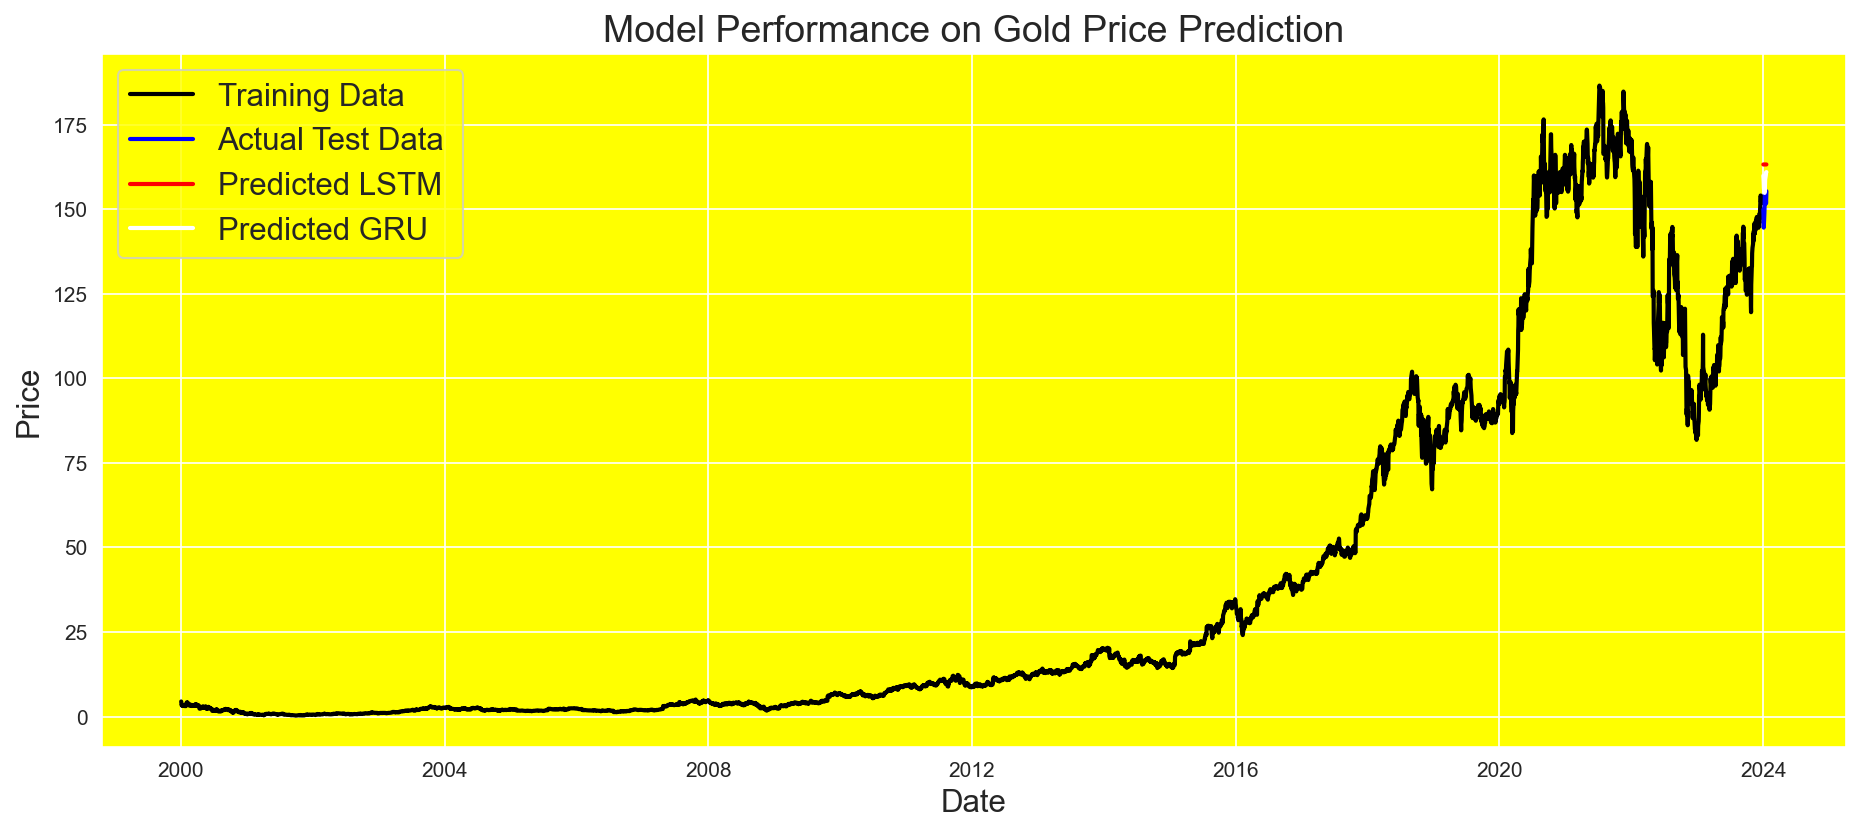

In [97]:
plt.figure(figsize=(15, 6), dpi=150)
plt.rcParams['axes.facecolor'] = 'yellow'
plt.rc('axes',edgecolor='white')
plt.plot(df['Date'].iloc[:-test_size], scaler.inverse_transform(train_data), color='black', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_true, color='blue', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred_lstm, color='red', lw=2)
plt.plot(df['Date'].iloc[-test_size:], y_test_pred_gru, color='white', lw=2)
plt.title('Model Performance on Gold Price Prediction', fontsize=18)
plt.xlabel('Date', fontsize=15)
plt.ylabel('Price', fontsize=15)
plt.legend(['Training Data', 'Actual Test Data', 'Predicted LSTM ','Predicted GRU'], loc='upper left', prop={'size': 15})
plt.grid(color='white')
plt.show()

Model Sarima

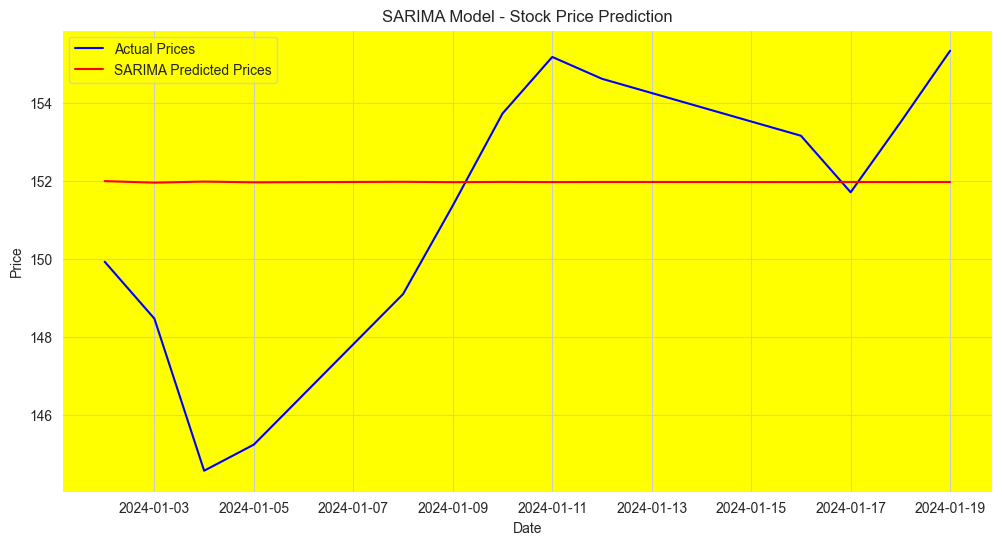

In [98]:
plt.figure(figsize=(12, 6))
plt.plot(df.Date[-test_size:], sarima_test_actual, label='Actual Prices', color='blue')
plt.plot(df.Date[-test_size:], sarima_test_pred, label='SARIMA Predicted Prices', color='red')
plt.title('SARIMA Model - Stock Price Prediction')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.grid(True)
plt.show()

# Kalman

In [99]:
 class KalmanFilter:
    def __init__(self, F, B, H, Q, R, P, x0):
        self.F = F  # State transition matrix
        self.B = B  # Control matrix
        self.H = H  # Observation matrix
        self.Q = Q  # Process noise covariance
        self.R = R  # Measurement noise covariance
        self.P = P  # Estimate error covariance
        self.x = x0 # Initial state estimate

    def predict(self, u=0):
        # Predict the state
        self.x = np.dot(self.F, self.x) + np.dot(self.B, u)
        # Predict the error covariance
        self.P = np.dot(np.dot(self.F, self.P), self.F.T) + self.Q
        return self.x

    def update(self, z):
        # Compute the Kalman Gain
        K = np.dot(np.dot(self.P, self.H.T), np.linalg.inv(np.dot(np.dot(self.H, self.P), self.H.T) + self.R))
        # Update the state estimate
        self.x = self.x + np.dot(K, (z - np.dot(self.H, self.x)))
        # Update the error covariance
        self.P = self.P - np.dot(np.dot(K, self.H), self.P)
        return self.x

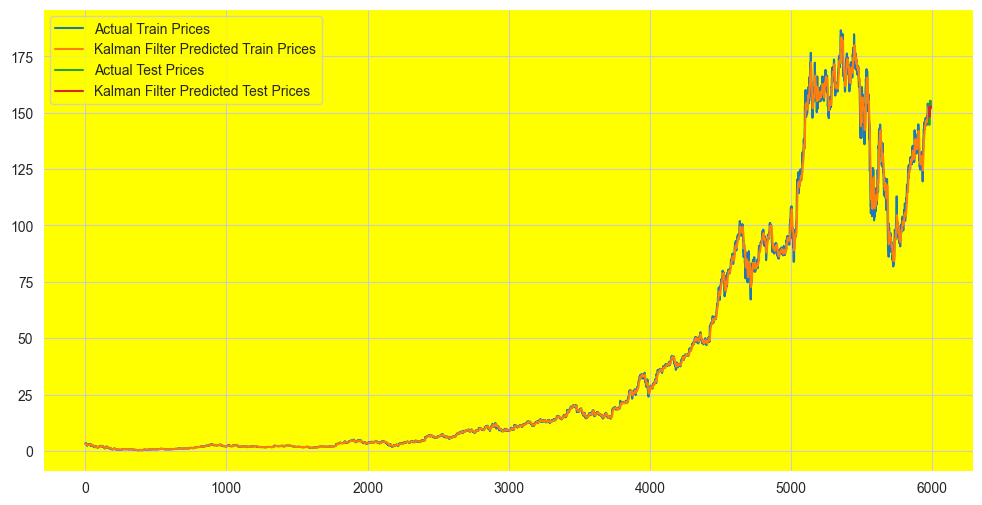

Train Mean Absolute Error (MAE): 0.8680130905922319
Train Mean Squared Error (MSE): 3.8312087050199626
Train Root Mean Squared Error (RMSE): 1.9573473644246089
0.029484757349037074
0.9529478032317599
Test Mean Absolute Error (MAE): 2.924643430129639
Test Mean Squared Error (MSE): 11.327598233342068
Test Root Mean Squared Error (RMSE): 3.365649749059172
0.019443942153060424
0.9529478032317599


In [100]:
window_size = 60
test_size = 13   

# Chia dữ liệu thành train và test
train_data = df.Close[:-test_size]
test_data = df.Close[-test_size-window_size:]

# Chuẩn hóa dữ liệu
scaler = MinMaxScaler(feature_range=(0, 1))
train_data = scaler.fit_transform(train_data.values.reshape(-1, 1))
test_data = scaler.transform(test_data.values.reshape(-1, 1))

X_train = []
y_train = []
for i in range(window_size, len(train_data)):
    X_train.append(train_data[i-window_size:i, 0])
    y_train.append(train_data[i, 0])

X_test = []
y_test = []
for i in range(window_size, len(test_data)):
    X_test.append(test_data[i-window_size:i, 0])
    y_test.append(test_data[i, 0])

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)
# Initialize Kalman Filter parameters
F = np.array([[1]])  # State transition matrix
B = np.array([[0]])  # Control matrix
H = np.array([[1]])   # Observation matrix
Q = np.array([[0.1]])  # Process noise covariance
R = np.array([[1]])  # Measurement noise covariance
P = np.array([[10]])  # Estimate error covariance
x0 = np.array([[y_train[0]]])  # Initial state estimate

kf = KalmanFilter(F, B, H, Q, R, P, x0)

# Train the Kalman Filter
predicted_train = []
for y in y_train:
    predicted_train.append(kf.predict() )
    kf.update(np.array([[y]]))

# Test the Kalman Filter
predicted_test = []
for y in y_test:
    predicted_test.append(kf.predict() )
    kf.update(np.array([[y]]))
     
 
# Inverse transform the predicted values
predicted_train = scaler.inverse_transform(np.array(predicted_train).reshape(-1, 1))
predicted_test = scaler.inverse_transform(np.array(predicted_test).reshape(-1, 1))
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test.shape
# Plot the results
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_train)), y_train, label='Actual Train Prices')
plt.plot(range(len(y_train)), predicted_train, label='Kalman Filter Predicted Train Prices')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Actual Test Prices')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), predicted_test, label='Kalman Filter Predicted Test Prices')
plt.legend()
plt.show()

# Evaluation metrics
mae_train = mean_absolute_error(y_train, predicted_train)
mse_train = mean_squared_error(y_train, predicted_train)
rmse_train = np.sqrt(mse_train)
MAPE_train = mean_absolute_percentage_error(y_train, predicted_train)
Accuracy_train = 1 - MAPE

mae_test = mean_absolute_error(y_test, predicted_test)
mse_test = mean_squared_error(y_test, predicted_test)
rmse_test = np.sqrt(mse_test)
MAPE_test = mean_absolute_percentage_error(y_test, predicted_test)
Accuracy_test = 1 - MAPE 

print(f'Train Mean Absolute Error (MAE): {mae_train}')
print(f'Train Mean Squared Error (MSE): {mse_train}')
print(f'Train Root Mean Squared Error (RMSE): {rmse_train}')
print(MAPE_train)
print(Accuracy_train)

print(f'Test Mean Absolute Error (MAE): {mae_test}')
print(f'Test Mean Squared Error (MSE): {mse_test}')
print(f'Test Root Mean Squared Error (RMSE): {rmse_test}')
MAPE = mean_absolute_percentage_error(y_test, predicted_test)
Accuracy = 1 - MAPE
print(MAPE_test)
print(Accuracy_test)


# GaussianHMM ket hop LSTM

### Tim trang thai an tot nhat 

In [101]:

from hmmlearn.hmm import GaussianHMM
best_n_state = None
best_score = float('inf')

for _ in range(5):
    for n_states in range(2,10):
        hmm_model = GaussianHMM(n_components=n_states, covariance_type="tied", n_iter=1000)
        hmm_model.fit(train_data)
        score = hmm_model.bic(train_data)
        if score < best_score:
            best_score = score
            best_n_state = n_states

print(f"so luong trang thai an tot nhat :{best_n_state}")        

so luong trang thai an tot nhat :9


### Xay dung mo hinh

In [102]:

hmm_model = GaussianHMM(n_components=9, covariance_type="tied", n_iter=1000)
hmm_model.fit(train_data)

# Lấy chuỗi trạng thái ẩn từ HMM 
hidden_states_train = hmm_model.predict(train_data).reshape(-1,1)
hidden_states_test = hmm_model.predict(test_data).reshape(-1,1)

#Kết hợp dữ liệu ban đầu và trạng thái ẩn làm đầu vào cho LSTM 
train_data_combined = np.hstack((train_data, hidden_states_train))
test_data_combined = np.hstack((test_data, hidden_states_test))


X_train = []
y_train = []
for i in range(window_size, len(train_data_combined)):
    X_train.append(train_data_combined[i-window_size:i, 0])
    y_train.append(train_data_combined[i, 0])

X_test = []
y_test = []
for i in range(window_size, len(test_data_combined)):
    X_test.append(test_data_combined[i-window_size:i, 0])
    y_test.append(test_data_combined[i, 0])

X_train = np.array(X_train)
X_test = np.array(X_test)
y_train = np.array(y_train)
y_test = np.array(y_test)


#Dinh nghia model LSTM
def define_model_lstm():
    input1 = Input(shape=(window_size,1))
    x = LSTM(units = 128, return_sequences=True)(input1)  
    x = Dropout(0.2)(x)
    x = LSTM(units = 64, return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 32,return_sequences=True)(x)
    x = Dropout(0.2)(x)
    x = LSTM(units = 16)(x)
    x = Dropout(0.2)(x)
    x = Dense(32, activation='softmax')(x)
    dnn_output = Dense(1)(x)

    model = Model(inputs=input1, outputs=[dnn_output])
    model.compile(loss='mean_squared_error', optimizer='adam')
    model.summary()
    
    return model

model_lstm = define_model_lstm()
history = model_lstm.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.1, verbose=1)

# Dự đoán giá cổ phiếu
train_predict = model_lstm.predict(X_train)
test_predict = model_lstm.predict(X_test)


# Chuyển đổi giá dự đoán về dạng ban đầu
train_predict = scaler.inverse_transform(np.array(train_predict).reshape(-1, 1))
test_predict = scaler.inverse_transform(np.array(test_predict).reshape(-1, 1))
y_train = scaler.inverse_transform(y_train.reshape(-1, 1))
y_test = scaler.inverse_transform(y_test.reshape(-1, 1))
y_test.shape

# Vẽ biểu đồ so sánh giá thực tế và giá dự đoán
plt.figure(figsize=(12, 6))
plt.plot(range(len(y_train)), y_train, label='Actual Train Prices')
plt.plot(range(len(y_train)), train_predict, label='GaussianHMM Predict Train Prices')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), y_test, label='Actual Test Prices')
plt.plot(range(len(y_train), len(y_train) + len(y_test)), test_predict, label='GauusianHMM Predict Test Prices')
plt.legend()
plt.show()

ValueError: as_list() is not defined on an unknown TensorShape.